<a href="https://colab.research.google.com/github/yewonlee5/yewonlee5.github.io/blob/main/Siamese%20Neural%20Networks%20(Thesis)/THESIS_MODEL3_Siamese_Triplet_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imports

%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import pandas as pd
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as F2

In [ ]:
# help functions

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
# configurations

class Config():
    training_dir = "./drive/MyDrive/thesis/output/train/"
    validating_dir = "./drive/MyDrive/thesis/output/val/"
    testing_dir = "./drive/MyDrive/thesis/output/test/"
    train_batch_size = 64
    train_number_epochs = 100

In [ ]:
# Define WhitePad

class WhitePad:
  def __call__(self, image):
    max_wh = max(image.size)
    p_left, p_top = [(max_wh - s)//2 for s in image.size]
    p_right, p_bottom = [max_wh - (s + pad) for s, pad in zip(image.size, [p_left, p_top])]
    padding = (p_left, p_top, p_right, p_bottom)
    return F2.pad(image, padding, 255, 'constant')

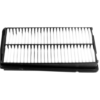

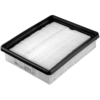

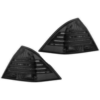

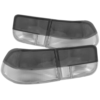

In [ ]:
# Examples

img1 = Image.open(r"./drive/MyDrive/thesis/output/train/Air Filter/042-1590.png")
img2 = Image.open(r"./drive/MyDrive/thesis/output/train/Air Filter/ACA1615CF.png")
img3 = Image.open(r"./drive/MyDrive/thesis/output/train/Tail Light/A1R221151.png")
img4 = Image.open(r"./drive/MyDrive/thesis/output/train/Tail Light/A1R221147.png")


transform=transforms.Compose([
    WhitePad(),
    transforms.Resize((100,100)),
    transforms.Grayscale()
    ])

img11 = transform(img1)
img22 = transform(img2)
img33 = transform(img3)
img44 = transform(img4)


img11.show() # Air Filter
img22.show()
img33.show() # Tail Light
img44.show()



In [ ]:
import cv2

class TripletDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        # self.is_train = train
        self.transform = transform

    def __getitem__(self, index):


        # if self.is_train:

            anchor_tuple = self.imageFolderDataset.imgs[index]
            anchor_label = anchor_tuple[1]

            random_list = self.imageFolderDataset.imgs[:index] + self.imageFolderDataset.imgs[index+1:]
            while True:
              positive_tuple = random.choice(random_list)
              #keep looping till the same class image is found
              if anchor_tuple[1]==positive_tuple[1]:
                break
            while True:
              negative_tuple = random.choice(random_list)
              #keep looping till a different class image is found
              if anchor_tuple[1]!=negative_tuple[1]:
                break

            anchor_img = Image.open(anchor_tuple[0])
            positive_img = Image.open(positive_tuple[0])
            negative_img = Image.open(negative_tuple[0])
            anchor_img = anchor_img.convert("L")
            positive_img = positive_img.convert("L")
            negative_img = negative_img.convert("L")

            if self.transform:
              anchor_img = self.transform(anchor_img)
              positive_img = self.transform(positive_img)
              negative_img = self.transform(negative_img)

            return anchor_img, positive_img, negative_img, anchor_label

        # else:
        #     anchor_tuple = random.choice(self.imageFolderDataset.imgs)
        #     anchor_img = Image.open(anchor_tuple[0])
        #     anchor_img = anchor_img.convert("L")

        #     if self.transform:
        #       anchor_img = self.transform(anchor_img)

        #     return anchor_img

    def __len__(self):
        return len(self.imageFolderDataset.imgs)



In [ ]:
# Thereshold -> using loss.mean()
# hard & semi-hard negatives
margin = 2.0

import cv2

class TripletDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        # self.is_train = train
        self.transform = transform

    def __getitem__(self, index):

        # if self.is_train:

            anchor_tuple = self.imageFolderDataset.imgs[index]
            anchor_label = anchor_tuple[1]
            while True:
            # positive random choice
              while True:

                random_list = self.imageFolderDataset.imgs[:index] + self.imageFolderDataset.imgs[index+1:]
                positive_tuple = random.choice(random_list)

                #keep looping till the same class image is found
                if anchor_tuple[1]==positive_tuple[1]:
                  break
              while True:
                #keep looping till a different class image is found
                negative_tuple = random.choice(random_list)

                if anchor_tuple[1]==negative_tuple[1]:
                  break


              anchor_img = Image.open(anchor_tuple[0])
              positive_img = Image.open(positive_tuple[0])
              negative_img = Image.open(negative_tuple[0])
              anchor_img = anchor_img.convert("L")
              positive_img = positive_img.convert("L")
              negative_img = negative_img.convert("L")

              if self.transform:
                anchor_img = self.transform(anchor_img)
                positive_img = self.transform(positive_img)
                negative_img = self.transform(negative_img)

              # only hard & semi-hard negatives
              # simple distance (before the model)
              ans = (anchor_img - positive_img).pow(2).sum(1) - (anchor_img - negative_img).pow(2).sum(1) - margin


              if ans.mean() <= 0:
                return anchor_img, positive_img, negative_img, anchor_label
                break


        # else:
        #     anchor_tuple = random.choice(self.imageFolderDataset.imgs)
        #     anchor_img = Image.open(anchor_tuple[0])
        #     anchor_img = anchor_img.convert("L")

        #     if self.transform:
        #       anchor_img = self.transform(anchor_img)

        #     return anchor_img

    def __len__(self):
        return len(self.imageFolderDataset.imgs)



In [ ]:
# image folder dataset

folder_dataset = dset.ImageFolder(root=Config.training_dir)
folder_dataset_val = dset.ImageFolder(root=Config.validating_dir)

In [ ]:
train_ds = TripletDataset(folder_dataset,
                 transform=transforms.Compose([
                                               WhitePad(),
                                               transforms.Resize((100,100)),
                                               transforms.ToTensor()
                                               ])
                 )


train_loader = DataLoader(train_ds, batch_size=Config.train_batch_size, shuffle=True, num_workers=8)

In [ ]:
val_ds = TripletDataset(folder_dataset_val,
                        transform=transforms.Compose([
                                               WhitePad(),
                                               transforms.Resize((100,100)),
                                               transforms.ToTensor()
                                               ])
                        )
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=6)

In [ ]:
# Define TripletLoss
margin = 2.0

class TripletLoss(nn.Module):
    def __init__(self, margin=margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [ ]:
# Define Neural Network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))


    def forward(self, x):
        output = self.cnn1(x)
        output = output.view( output.size()[0], -1) # x = x.view(-1, 64*4*4)
        output = self.fc1(output)
        # x = nn.functional.normalize(x)
        return output

In [ ]:
# weight initialize
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [ ]:
# Create Instances

model = Network()
model.apply(init_weights)
model = torch.jit.script(model).cuda()

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = torch.jit.script(TripletLoss())

In [ ]:
# Training Loop
from tqdm import tqdm

# Execution time
import time

# get starting time
start = time.time()


train_losses = []
val_losses = []

train_accuracy = []
val_accuracy = []


model.train()
for epoch in tqdm(range(Config.train_number_epochs), desc="Epochs"):
    running_loss = 0.0
    correct = 0.0
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.cuda()
        positive_img = positive_img.cuda()
        negative_img = negative_img.cuda()

        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        ans = (anchor_out - negative_out).pow(2).sum(1) - (anchor_out - positive_out).pow(2).sum(1) - margin

        if ans.mean().item() >= 0:
          correct += 1

        if step % 10 == 0:
          print("Epoch number {} , Current Train Loss {}".format(epoch+1, loss.item()))

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    avg_train_accuracy = correct / len(train_loader)
    train_accuracy.append(avg_train_accuracy)

    # check validation loss after every epoch
    val_running_loss = 0.0
    val_correct = 0.0
    with torch.no_grad():
      model.eval()
      for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(val_loader, desc="Training", leave=False)): ##
        anchor_img = anchor_img.cuda()
        positive_img = positive_img.cuda()
        negative_img = negative_img.cuda()

        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss = criterion(anchor_out, positive_out, negative_out)

        ans = (anchor_out - negative_out).pow(2).sum(1) - (anchor_out - positive_out).pow(2).sum(1) - margin

        if ans.mean().item() >= 0:
          correct += 1

        val_running_loss += loss.item()

      avg_val_loss = val_running_loss / len(val_loader)
      val_losses.append(avg_val_loss)
      avg_val_accuracy = correct / len(val_loader)
      val_accuracy.append(avg_val_accuracy)

      elapsed_time = (time.time() - start)

      print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}, Accumulated Execution time: {:.2f}'.format(epoch+1, Config.train_number_epochs, avg_train_loss, avg_val_loss, elapsed_time))
      print('Epoch [{}/{}],Train Accuracy : {:.8f}, Valid Accuracy: {:.8f}'.format(epoch+1, Config.train_number_epochs, avg_train_accuracy, avg_val_accuracy))

      # For each epoch, save model checkpoint
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, '/content/drive/MyDrive/thesis/checkpoint_Triplet_50.pth')
      # For each epoch, save loss & accuracy
      # df = pd.DataFrame({'training_loss': train_losses, 'validation_loss': val_losses} )
      df = pd.DataFrame({'training_loss': train_losses, 'validation_loss': val_losses,  'validation_accuracy': val_accuracy} )
      df.to_csv('/content/drive/MyDrive/thesis/model3_loss_accuracy.csv')

elapsed_time = (time.time() - start)
print("Finished Training")
print(elapsed_time)

In [ ]:
x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float)
y = torch.tensor([[9, 8, 7], [6, 5, 4], [3, 2, 1]], dtype=torch.float)

ex1 = torch.norm(x - y, dim=1)
ex1

tensor([10.7703,  2.8284, 10.7703])

In [ ]:
ex2 = (y-x).pow(2).sum(1)

In [ ]:
ex1

tensor([10.7703,  2.8284, 10.7703])

In [ ]:
ex2

tensor([116.,   8., 116.])

In [ ]:
a = ex1-ex2

In [ ]:
a = torch.relu(ex1-ex2)

In [ ]:
a.mean().item()

-71.87696838378906

In [ ]:
# Save Params

# save
torch.save(model.state_dict(), '/content/drive/MyDrive/thesis/checkpoint_Triplet3.pth')

# Triplet1 : margin = 1.0
# Triplet2 : margin = 0.005
# Triplet3 : margin = 2.0 & fixed dataset

In [ ]:
# load the state
state_dict = torch.load(r"/content/drive/MyDrive/thesis/checkpoint_Triplet3.pth")
print(state_dict.keys())

odict_keys(['cnn1.1.weight', 'cnn1.1.bias', 'cnn1.3.weight', 'cnn1.3.bias', 'cnn1.3.running_mean', 'cnn1.3.running_var', 'cnn1.3.num_batches_tracked', 'cnn1.5.weight', 'cnn1.5.bias', 'cnn1.7.weight', 'cnn1.7.bias', 'cnn1.7.running_mean', 'cnn1.7.running_var', 'cnn1.7.num_batches_tracked', 'cnn1.9.weight', 'cnn1.9.bias', 'cnn1.11.weight', 'cnn1.11.bias', 'cnn1.11.running_mean', 'cnn1.11.running_var', 'cnn1.11.num_batches_tracked', 'fc1.0.weight', 'fc1.0.bias', 'fc1.2.weight', 'fc1.2.bias', 'fc1.4.weight', 'fc1.4.bias'])


In [ ]:
# load the state dict into the model
model.load_state_dict(state_dict)

<All keys matched successfully>

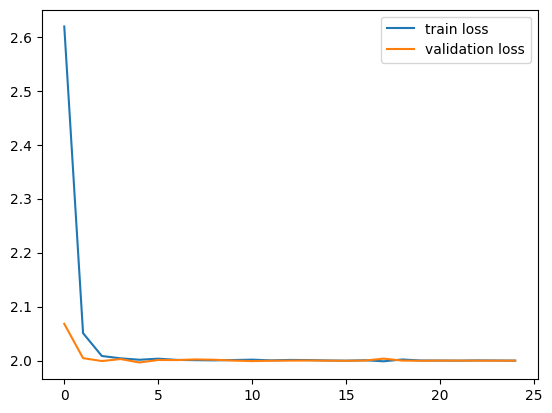

In [ ]:
# Model3 # Plot

x = [i for i in range(Config.train_number_epochs)]

plt.plot(x, train_losses, label = "train loss")
plt.plot(x, val_losses, label = "validation loss")
plt.legend()
plt.show()

In [ ]:
# Model3 # Plot # 100

plt.style.use("seaborn-darkgrid")

x = [i for i in range(Config.train_number_epochs)]

plt.plot(x, train_losses, label = "train loss", color = '#fde725')
plt.plot(x, val_losses, label = "validation loss", color = '#440154')
plt.viridis()
plt.legend()
plt.show()

In [ ]:
# Accuracy History _ 100

plt.style.use("seaborn-darkgrid")

x = [i for i in range(Config.train_number_epochs)]

plt.plot(x, train_accuracy, label = "train accuracy", color = '#fde725')
plt.plot(x, val_accuracy, label = "validation accuracy", color = '#440154')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.viridis()
plt.legend()
plt.show()

In [ ]:
# test result

train_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(train_loader):
        train_results.append(model(img.cuda()).cpu().numpy())
        labels.append(label)

train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

Test

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)

test_ds = TripletDataset(folder_dataset_test,
                        transform=transforms.Compose([
                                               WhitePad(),
                                               transforms.Resize((100,100)),
                                               transforms.ToTensor()
                                               ])
                        )
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=6)

In [ ]:
accuracy=0
counter=0
correct=0

# margin = 2.0

for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(test_loader):
  anchor_img = anchor_img.cuda()
  positive_img = positive_img.cuda()
  negative_img = negative_img.cuda()

  anchor_out = model(anchor_img)
  positive_out = model(positive_img)
  negative_out = model(negative_img)

  ans = (anchor_out - negative_out).pow(2).sum(1) - (anchor_out - positive_out).pow(2).sum(1) - margin

  if  ans.mean().item() >0 :
    correct += 1


accuracy=(correct/len(test_loader))*100
print("Accuracy:{}%".format(accuracy))

In [ ]:
# Precision Score = TP / (FP + TP)
# specificity

precision=0
TP=0
FP=0

for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(test_loader):
  anchor_img = anchor_img.cuda()
  positive_img = positive_img.cuda()
  negative_img = negative_img.cuda()

  anchor_out = model(anchor_img)
  positive_out = model(positive_img)
  negative_out = model(negative_img)

  if (anchor_out - positive_out).pow(2).sum(1) < (anchor_out - negative_out).pow(2).sum(1):
    correct += 1


precision=(correct/len(test_loader))*100
print("Precision:{}%".format(precision))